In [257]:
import csv

def get_disk_results(file):
    data = {}
    with open(file, newline='') as csvfile:
        data_reader = csv.reader(csvfile, delimiter=',')
        for row in data_reader:
            data[row[0]] = data[row[0]] if row[0] in data else {}
            data[row[0]][row[1]] = {
                'ops': int(row[2]),
                'ops/sec': float(row[3]),
                'rd/wr': row[4],
                'mb/s': float(row[5]),
                'ms/op': float(row[6])
            }
    return data

In [258]:
import csv

def get_alg_csv_results(file):
    data = {}
    with open(file, newline='') as csvfile:
        data_reader = csv.reader(csvfile, delimiter=',')
        for row in data_reader:
            # alg,ops,ops/sec,rd/wr,mb/s,ms/op,read hits,read misses,write hits,write misses,demotions,promotions,blocks in cache,dirty
            data[row[0]] = data[row[0]] if row[0] in data else {}
            data[row[0]][row[1]] = data[row[0]][row[1]] if row[1] in data[row[0]] else {}
            if len(row) < 23: row += ([0]*7)
            data[row[0]][row[1]][row[2]] = {
                'ops': int(row[3]),
                'ops/sec': float(row[4]),
                'rd/wr': row[5],
                'mb/s': float(row[6]),
                'ms/op': float(row[7]),
                'read hits': int(row[8]),
                'read misses': int(row[9]),
                'write hits': int(row[10]),
                'write misses': int(row[11]),
                'demotions': int(row[12]),
                'promotions': int(row[13]),
                'blocks in cache': int(row[14]),
                'dirty': int(row[15]),
                'sylab_ios': int(row[16]),
                'sylab_hits': int(row[17]),
                'sylab_misses': int(row[18]),
                'sylab_filtered': int(row[19]),
                'sylab_lockfail': int(row[20]),
                'sylab_skipped': int(row[21]),
                'sylab_promoted': int(row[22]),
                'sylab_demoted': int(row[23]),
            }
            
            alg_data = data[row[0]][row[1]][row[2]]
            
            alg_data['read ios'] = alg_data['read hits'] + alg_data['read misses']
            alg_data['write ios'] = alg_data['write hits'] + alg_data['write misses']
            
            alg_data['hit-rate'] = (alg_data['read hits'] + alg_data['write hits']) / (alg_data['read ios'] + alg_data['write ios']+alg_data['promotions'])
            alg_data['read hit-rate'] = alg_data['read hits'] / alg_data['read ios']
            alg_data['write hit-rate'] = alg_data['write hits'] / alg_data['write ios']
            alg_data['sylab hit-rate'] = alg_data['sylab_hits'] / alg_data['sylab_ios']
            
    return data

In [259]:
wb_data = get_alg_csv_results('writeback.results')
wt_data = get_alg_csv_results('writethrough.results')

In [260]:
wb_data['name'] = 'Writeback'
wt_data['name'] = 'Writethrough'

In [261]:
MIN_CACHE_SIZE=16367
MAX_MULT=4#6
cache_sizes = [ str(MIN_CACHE_SIZE * (2 ** mult)) for mult in range(0,MAX_MULT) ]

In [262]:
# m* comparison graph function for visualizing result data

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math

def add_mstar(data, algs):
    new_algs = []
    for alg in algs:
        new_algs.append(alg)
        if 'm'+alg in data:
            new_algs.append('m'+alg)
        if 'm'+alg+'_lw' in data:
            new_algs.append('m'+alg+'_lw')
    return new_algs

def m_compare_graph(data, stat, name, workload, algs):
    sizes = list(data[algs[0]][workload].keys())
    x = np.arange(len(sizes))

    fig = plt.figure(figsize=(16,6))
    
    algs = add_mstar(data, algs)
    
    #get indexes and y-values
    index = np.arange(len(sizes))
    bar_width = 0.9 / float(len(algs))
    opacity = 0.8
    
    for i, algo in enumerate(algs):
        values = []
        for size in sizes:
            # plot bar
            values.append(data[algo][workload][size][stat])
        plt.bar(index + (i*bar_width), values,  bar_width, alpha=opacity, label=algo)
    
    # see disk stat for comparison
    #for disk in disk_data.keys():
    #    if stat in disk_data[disk][workload]:
    #        y = [ disk_data[disk][workload][stat] ] * len(x)
    #
    #       plt.plot(x, y, color='r', label=disk)
    
    x_labels = list(map(lambda x: "{} MB".format(
        math.ceil((float(data[algs[0]][workload][x]['blocks in cache']) * (32 * 2**10))/(2**20))),
        sizes))
    plt.xlabel('Cache Size')
    plt.ylabel(stat)
    plt.xticks(x + ((len(algs)/2) * bar_width), x_labels)
    plt.legend()
    plt.title('{} Performance for {} using {}'.format(name, workload, data['name']))
    
    plt.legend(loc='upper center', bbox_to_anchor=(1.05, 0.8), ncol=1)
    
    plt.tight_layout()
    plt.show()

In [263]:
#workloads = ['fileserver.f.2g', 'webserver.f.2g']
workloads = ['fileserver.f.2g']
algs = ['lru', 'arc', 'larc', 'lecar']
result_data = [ wt_data ]

In [264]:
def get_results(data_type, data_label, use_writethrough=True):
    for workload in workloads:
        #for alg in algs:
        for data in result_data:
            m_compare_graph(data, data_type, data_label, workload, algs)

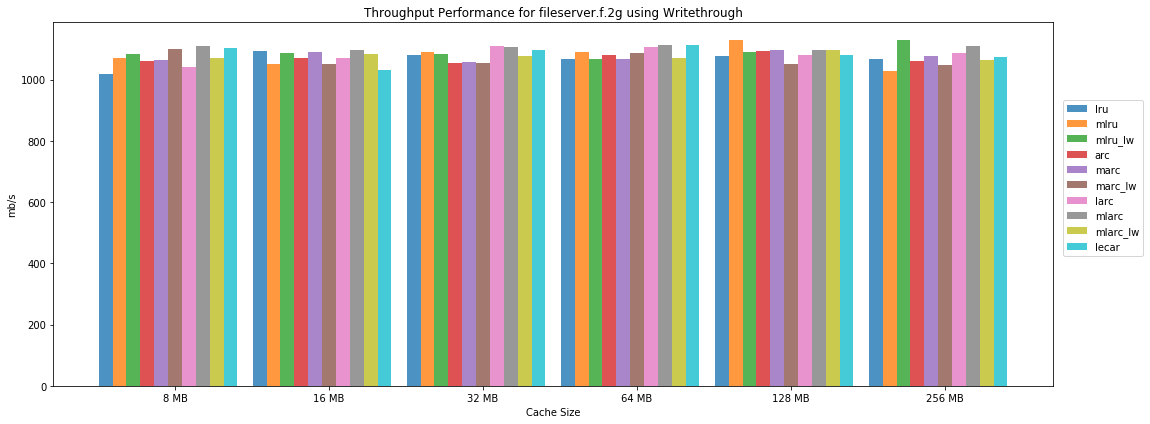

In [265]:
# Throughput Graph
get_results('mb/s', 'Throughput')

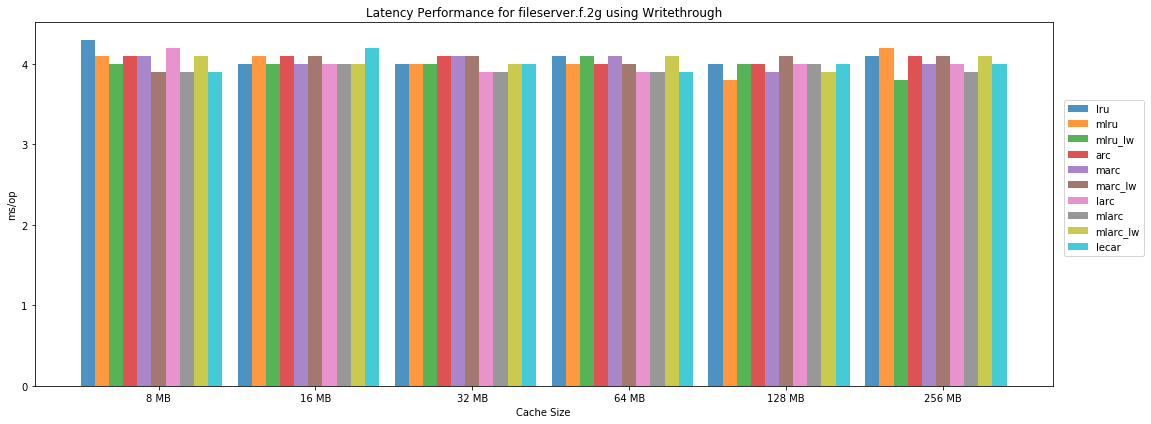

In [266]:
# Latency Graph
get_results('ms/op', 'Latency')

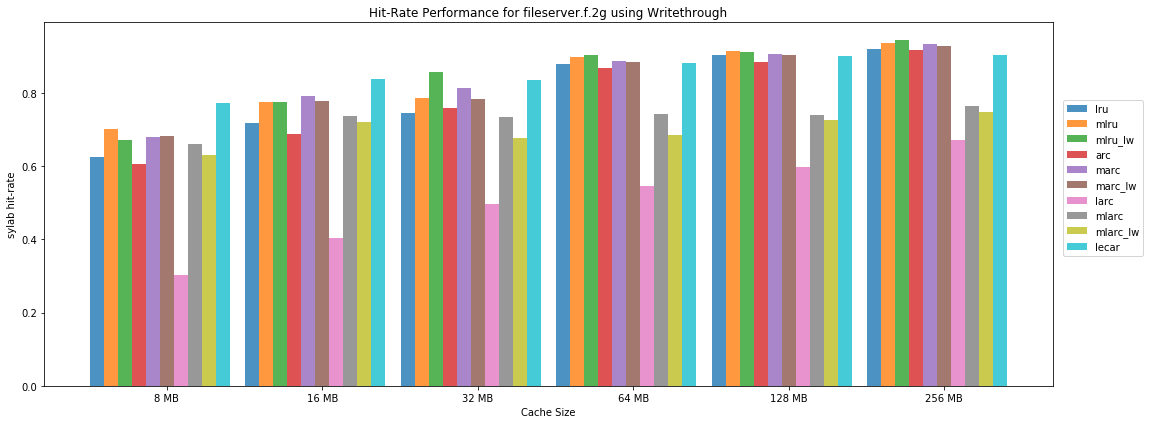

In [267]:
# "SyLab" Hit-rate
get_results('sylab hit-rate', 'Hit-Rate')

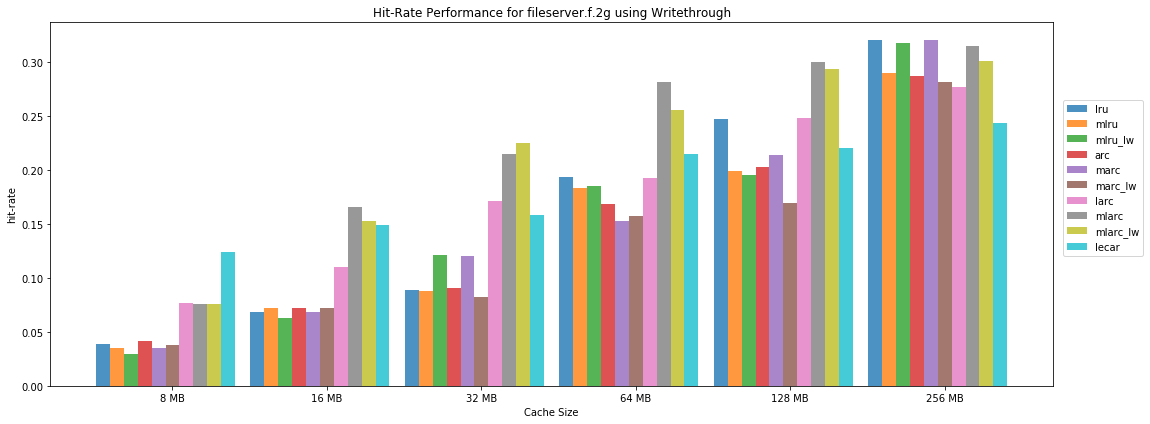

In [268]:
# Hitrate Graph
get_results('hit-rate', 'Hit-Rate')

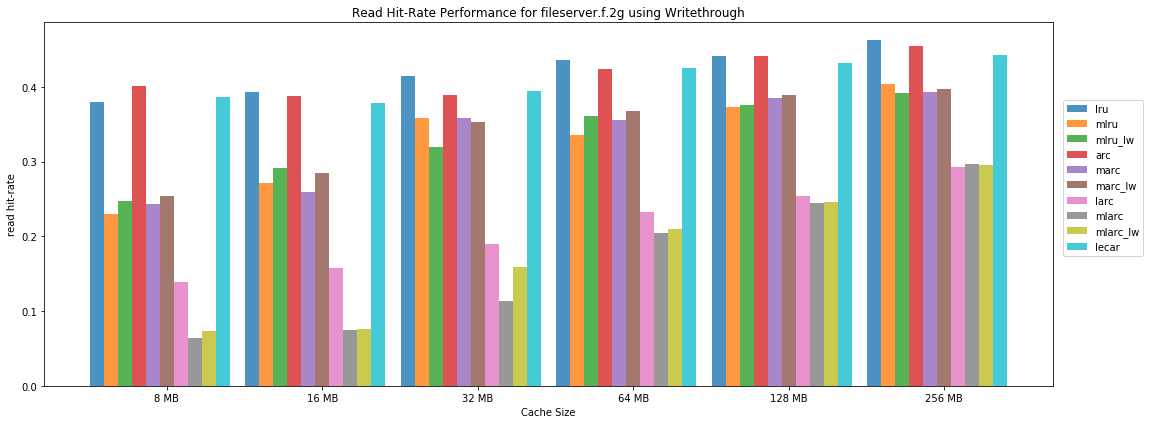

In [269]:
# Read Hit-Rate
get_results('read hit-rate', 'Read Hit-Rate')

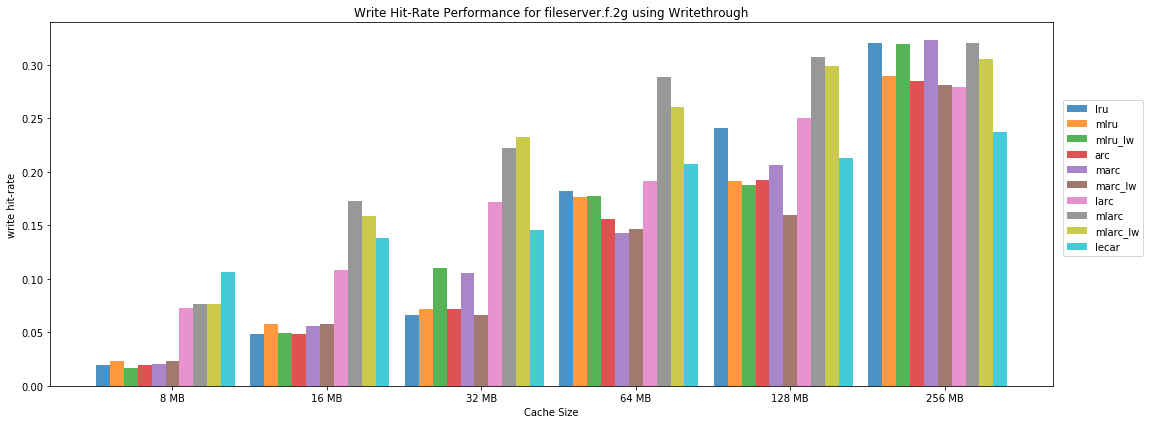

In [270]:
# Write Hit-Rate
get_results('write hit-rate', 'Write Hit-Rate')

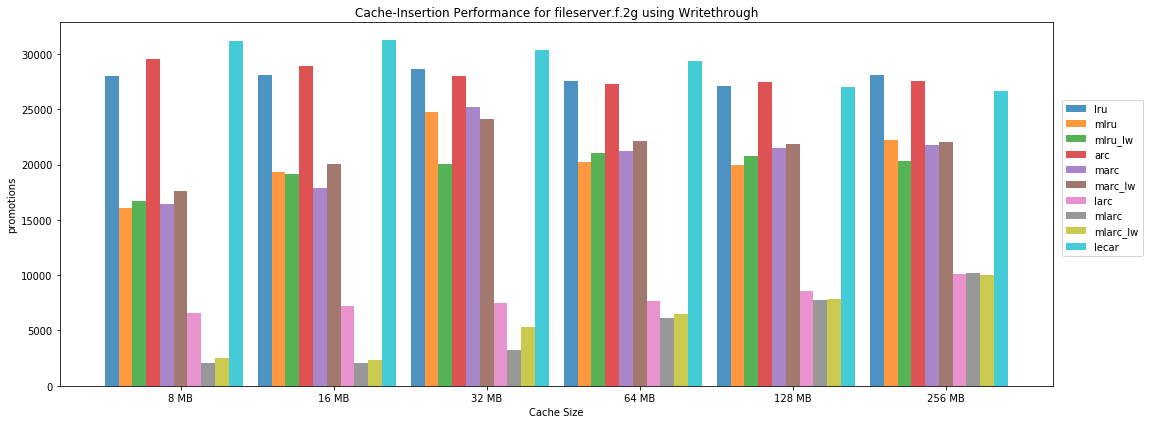

In [271]:
# Cache-Insertion Graph
get_results('promotions', 'Cache-Insertion')

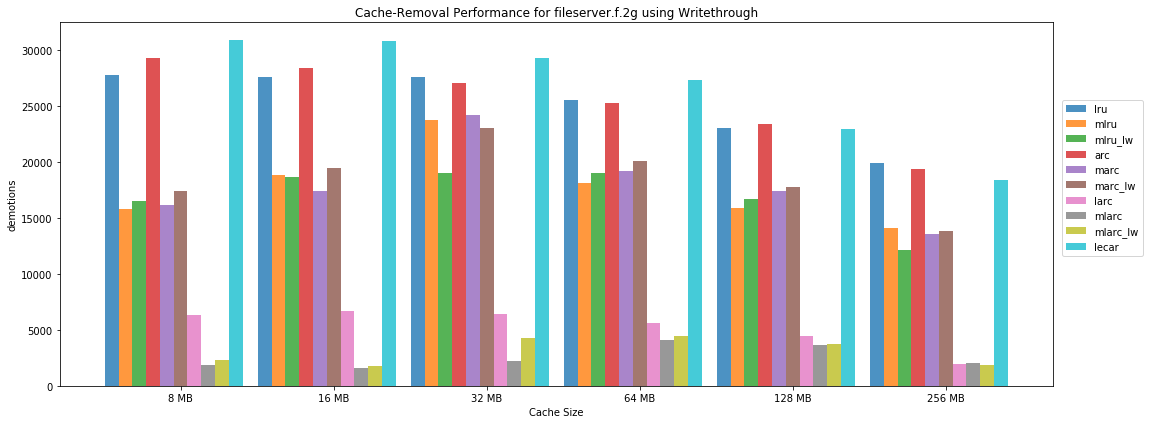

In [272]:
get_results('demotions', 'Cache-Removal')

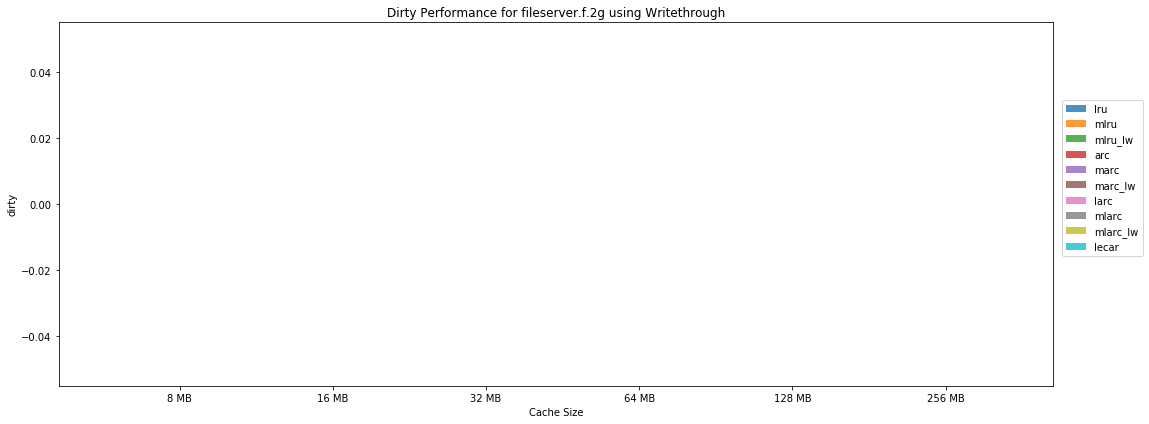

In [273]:
# Writeback Dirty Graph
get_results('dirty', 'Dirty', use_writethrough=False)

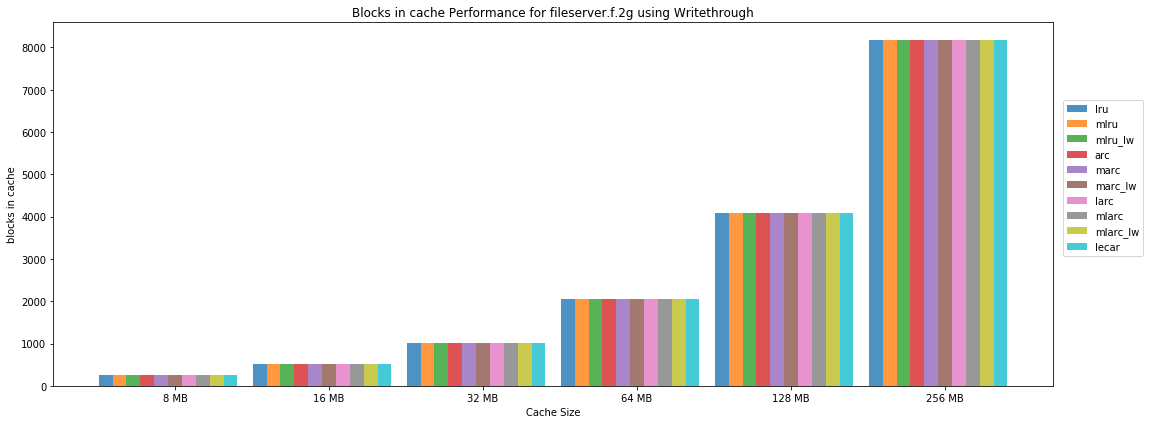

In [274]:
get_results('blocks in cache', 'Blocks in cache')

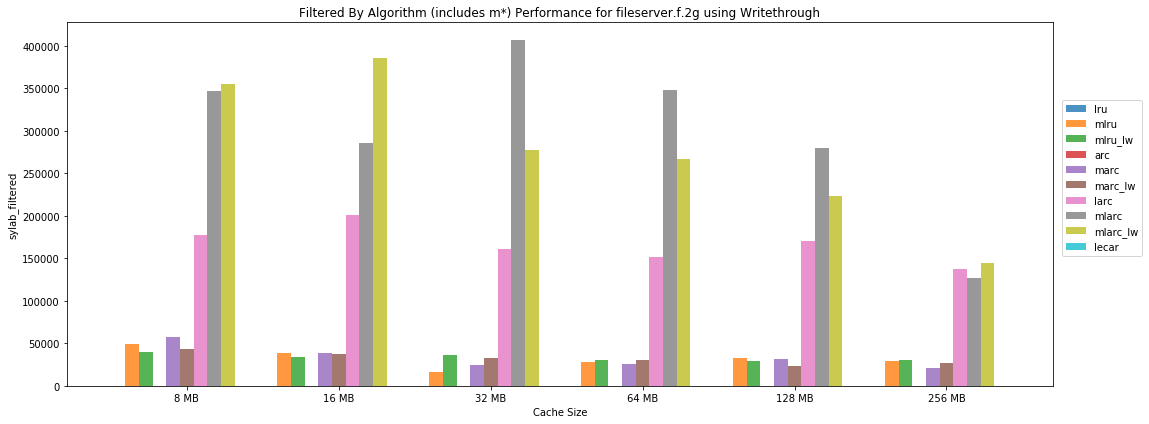

In [275]:
get_results('sylab_filtered', 'Filtered By Algorithm (includes m*)')

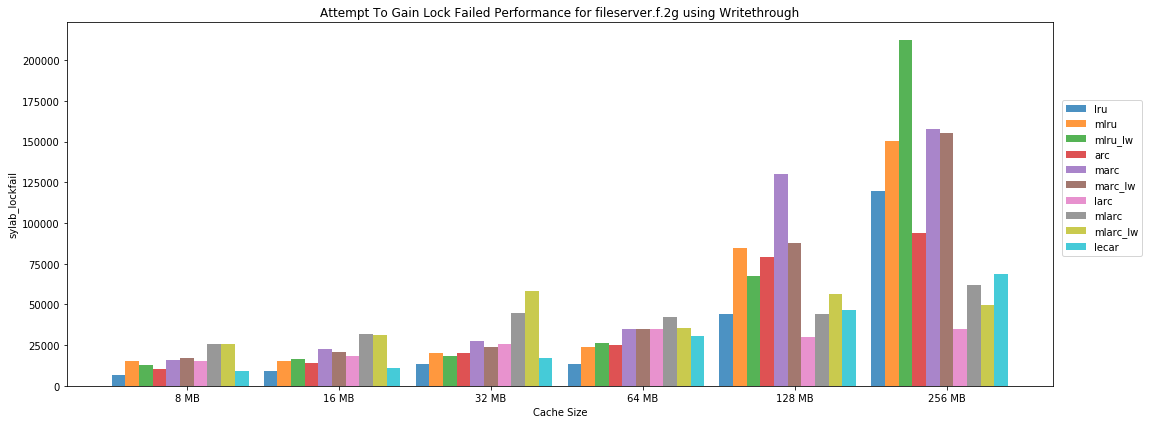

In [276]:
get_results('sylab_lockfail', 'Attempt To Gain Lock Failed')

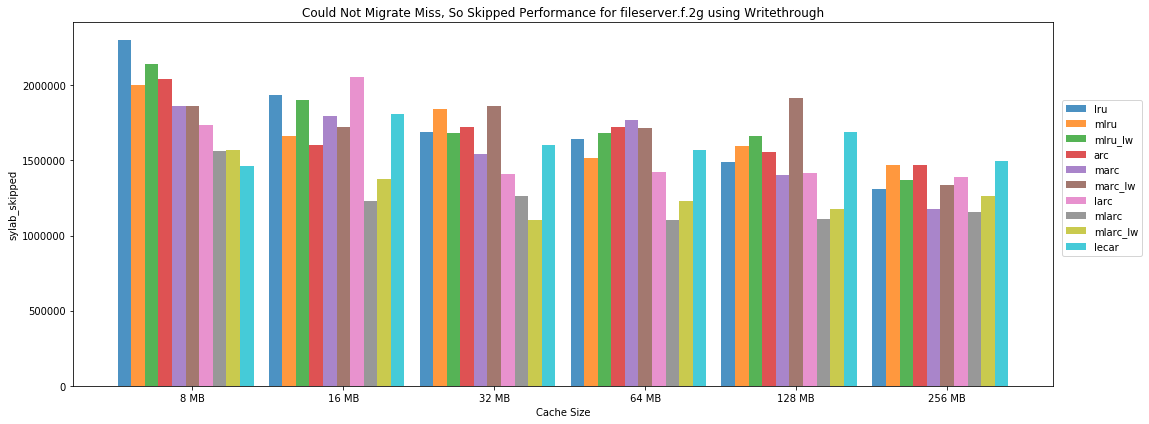

In [277]:
get_results('sylab_skipped', 'Could Not Migrate Miss, So Skipped')

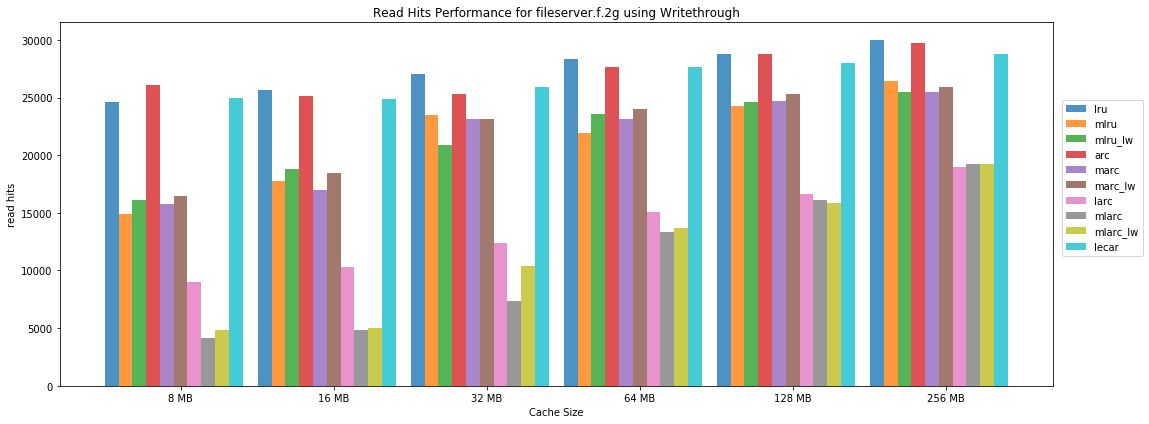

In [278]:
get_results('read hits', 'Read Hits')

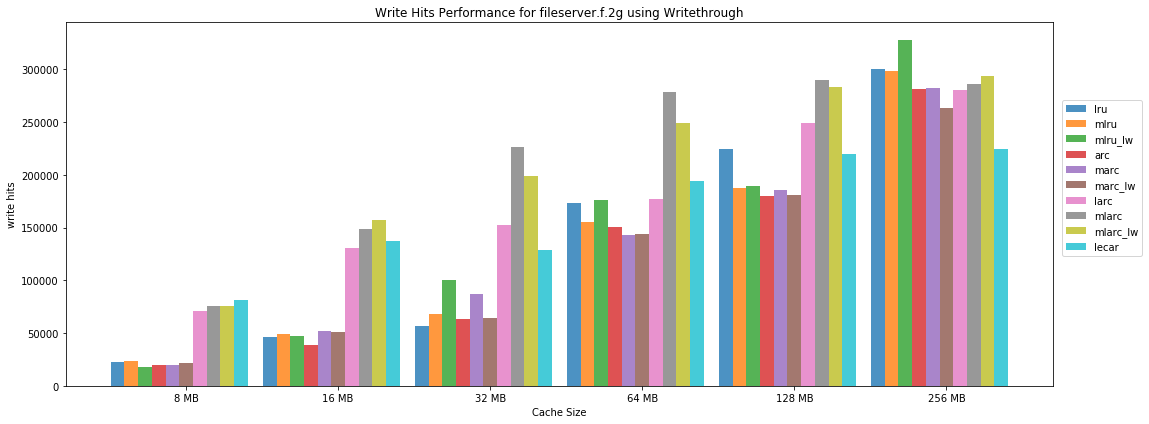

In [279]:
get_results('write hits', 'Write Hits')